In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


2026-01-24 10:00:40.491933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-24 10:00:40.491990: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BASE_DIR = "/home/muskan/Keras/Skin Cancer Detection System with CNN/Melanoma Cancer Image Dataset/"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [3]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32     # to read images in 32 batches 


train_dataget = ImageDataGenerator(
    rescale =1./255,   # To bring image pixel in 0 and 1 form
    rotation_range = 20,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,   # To shear image
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataget.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Print class labels
print("Class Mapping:", train_generator.class_indices)


Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


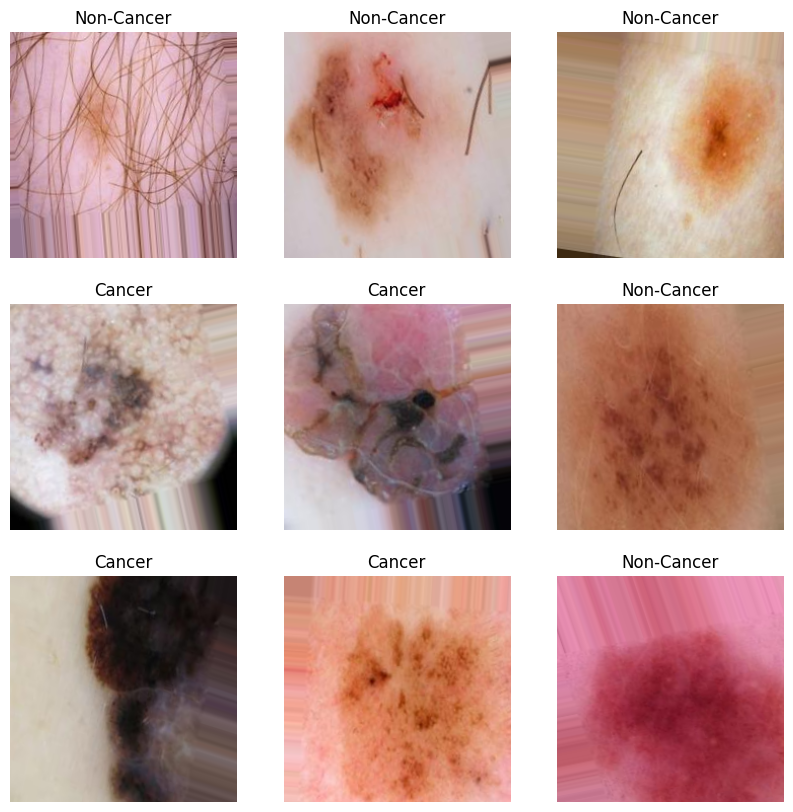

In [4]:
# EDA(EXPLOARTORY DATA ANAYLSIS)

def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i])
        plt.title('Cancer' if labels[i] == 1 else "Non-Cancer")
        plt.axis('off')
    plt.show()

plot_images(train_generator)

In [5]:
# Build CNN Model

from tensorflow.keras import layers, models

model = models.Sequential([
    # 1st Convolution block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    
    # 2nd convolutional block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    # 3rd covolution blobk
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    # classification
    layers.Flatten(),
    
    # fully connected part(output layer)
    layers.Dense(515, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # output layer
    
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()


2026-01-24 10:00:50.603130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-01-24 10:00:50.603203: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2026-01-24 10:00:50.603240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (muskan-Lenovo-IdeaPad-S145-15API): /proc/driver/nvidia/version does not exist
2026-01-24 10:00:50.604414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-24 10:00:50.990278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocati

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
# Train and Evaluate model
# Early stopping to stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving 
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=3,
    factor=0.30,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //BATCH_SIZE,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples //BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler] # lr_scheduler is learning scheduler 
)

Epoch 1/30


2026-01-24 10:00:52.622986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 178247680 exceeds 10% of free system memory.
2026-01-24 10:00:52.685826: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 178247680 exceeds 10% of free system memory.


371/371 [==============================] - 917s 2s/step - loss: 0.5455 - accuracy: 0.7381 - val_loss: 0.5673 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 2/30
371/371 [==============================] - 909s 2s/step - loss: 0.4270 - accuracy: 0.8032 - val_loss: 0.3651 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 3/30
371/371 [==============================] - 688s 2s/step - loss: 0.4098 - accuracy: 0.8151 - val_loss: 0.3733 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 4/30
371/371 [==============================] - 678s 2s/step - loss: 0.3889 - accuracy: 0.8293 - val_loss: 0.3805 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 5/30
371/371 [==============================] - 676s 2s/step - loss: 0.3676 - accuracy: 0.8388 - val_loss: 0.3343 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 6/30
371/371 [==============================] - 796s 2s/step - loss: 0.3676 - accuracy: 0.8397 - val_loss: 0.3879 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 7/30
371/371 [==============================] - 885s 2s/step - loss: 

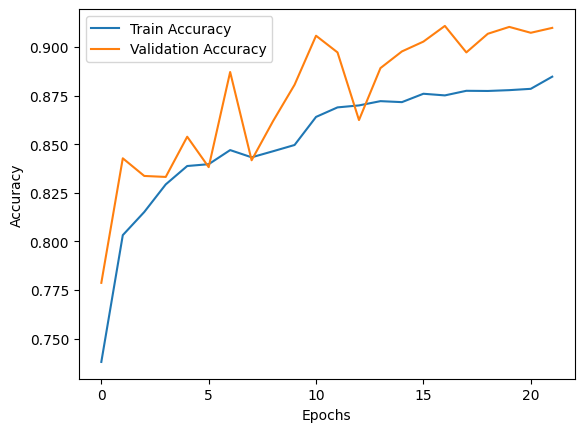

In [7]:
# Save model
model.save("skin_cancer_cnn.h5")

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [12]:
# Evaluate the Model
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))



62/62 [==============================] - 38s 616ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1000
           1       0.49      0.49      0.49       984

    accuracy                           0.49      1984
   macro avg       0.49      0.49      0.49      1984
weighted avg       0.49      0.49      0.49      1984



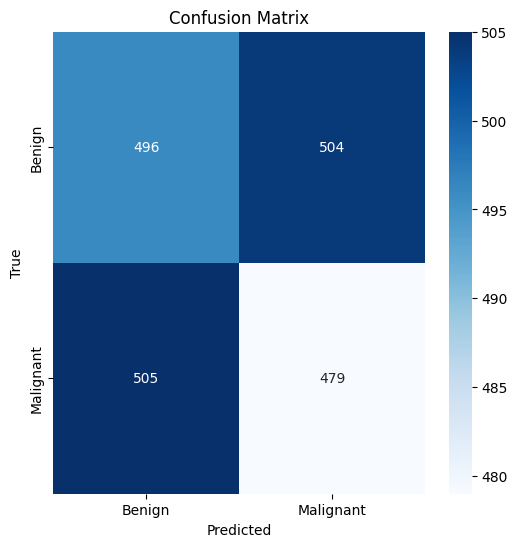

In [13]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Prediction System
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model("skin_cancer_cnn.h5")

def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predcited: {class_label}")
    plt.axis("off")
    plt.show()
    
    

1/1 [==============================] - 0s 256ms/step


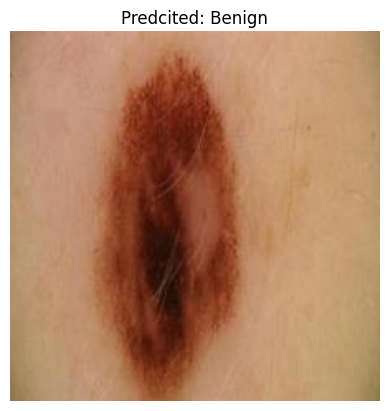

In [16]:
# Test on new image
predict_skin_cancer("/home/muskan/Keras/Skin Cancer Detection System with CNN/Melanoma Cancer Image Dataset/test/Benign/6337.jpg", model)
